# Preliminaries

This notebook lets you import a gym environment and set up an agent that acts within the environment. Your tasks is to then implement some of the classical RL algorithms: Value iteration and Policy iteration. Play attention to how you are going to evaluate your agents.

First, we make sure that all dependencies are met

In [147]:
!pip install gym > /dev/null 2>&1

# Testing the Gym environments

Our next step is to import the gym package, create an environment, and make sure that we can use it.

In [148]:
%matplotlib notebook
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, linewidth=200)
frames = [] # for animation

env = gym.make('Taxi-v3')
state = env.reset()
total_reward = 0
done = False
while not done:
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  frames.append({'frame': env.render(mode='ansi'),'state': obs,'action': action,'reward': reward})
  total_reward += reward

In [149]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames,delay=0.2):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.25)
        
print_frames(frames, 0.25)
print('Total reward: ' + str(total_reward))

+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Timestep: 200
State: 238
Action: 2
Reward: -1
Total reward: -866


# Defining an agent

The next step is to define a class for our agents. We will derive from this class to later implement a Value Iteration, Policy Iteration and Monte Carlo control agent. The base class will only provide simple functionality.

In [150]:
class Agent():
  def __init__(self,env,discount_factor):
    self.env = env
    self.gamma = discount_factor
  
  def act(self, state):
    return self.env.action_space.sample() #returns a random action

  def evaluate(self):
    # now let's test our random action agent
    n_steps = 100 #number of steps per episode

    s = env.reset()
    episode_reward = 0
    
    for i in range(n_steps):
      s, r, d, _ = env.step(self.act(s))
      episode_reward += r
      if d:
        break
    return episode_reward

#test simple evaluation function
random_agent = Agent(env,0.99)
episode_reward=random_agent.evaluate()
print("Episode return {}".format(episode_reward))

Episode return -352


# TD Agent, base class

In [151]:
class TDAgent(Agent):
  def __init__(self,env,discount_factor,alpha,epsilon):
    super().__init__(env,discount_factor)
    self.alpha = alpha
    self.epsilon = epsilon
    self.Q = np.random.rand(self.env.nS, self.env.nA)
    

  def act(self, state): 
    #here choose action according to the epsilon-greedy policy
    sample = np.random.rand()
    if sample > self.epsilon:
      action = np.argmax(self.Q[state,:].flatten())
    else:
      actions = list(range(self.env.nA))
      greedy_action = np.argmax(self.Q[state,:].flatten())
      actions.pop(actions.index(greedy_action))
      action = random.choice(actions)
    return action

 
    
  def run_episodes(self, n, batch_length):
    samp_rewards = deque(maxlen=100)
    best_avg_reward = -math.inf
    avg_rewards = []
    rewards = []
    i_batch = 1

    for i in range(n):
      rewards.append(self.run_one_episode())
      samp_rewards.append(rewards[-1])
      if (i >= 100):
        # get average reward from last 100 episodes
        avg_reward = np.mean(samp_rewards)
        # append to deque
        avg_rewards.append(avg_reward)
        # update best average reward
        if avg_reward > best_avg_reward:
          best_avg_reward = avg_reward
        if best_avg_reward >= 9.7:
          print('\nEnvironment solved in {} episodes.'.format(i), end="")
          break
      if (i%batch_length == 0):
        self.epsilon /= (i_batch+1)#*= .9 
        i_batch += 1

    return(rewards, avg_rewards)

# SARSA Agent



In [152]:
from collections import deque
class SARSAAgent(Agent):
  def __init__(self,env,discount_factor,alpha,epsilon):
    super().__init__(env,discount_factor)
    self.alpha = alpha
    self.epsilon = epsilon
    self.Q = np.random.rand(self.env.nS, self.env.nA)
    

  def act(self, state): 
    #here choose action according to the epsilon-greedy policy
    sample = np.random.rand()
    if sample > self.epsilon:
      action = np.argmax(self.Q[state,:].flatten())
    else:
      actions = list(range(self.env.nA))
      greedy_action = np.argmax(self.Q[state,:].flatten())
      actions.pop(actions.index(greedy_action))
      action = random.choice(actions)
    return action

   
  def run_one_episode(self):
    
    episode = []
    done = False
    total_reward = 0
    self.env.reset()
   
    state = self.env.s
    action = self.act(state)
    
    while (not done):
      new_state, reward, done, _ = self.env.step(action)      
      # Select next action
      new_action = self.act(new_state)
      
      # Update Q
      self.Q[state,action] += self.alpha * (reward + self.gamma * self.Q[new_state,new_action] - self.Q[state,action]) 

      state = new_state
      action = new_action
      total_reward += reward
   
    return total_reward
    
  def run_episodes(self, n, batch_length):
    
    samp_rewards = deque(maxlen=100)
    best_avg_reward = -math.inf
    avg_rewards = []
    rewards = []
    ibatch = 1

    for i in range(n):
      rewards.append(self.run_one_episode())
      samp_rewards.append(rewards[-1])
      if (i >= 100):
        # get average reward from last 100 episodes
        avg_reward = np.mean(samp_rewards)
        # append to deque
        avg_rewards.append(avg_reward)
        # update best average reward
        if avg_reward > best_avg_reward:
          best_avg_reward = avg_reward
        if best_avg_reward >= 9.7:
          print('\nEnvironment solved in {} episodes.'.format(i), end="")
          break
      if (i%batch_length == 0):
        self.epsilon /= (ibatch+1) 
        ibatch +=1

     
    return(rewards, avg_rewards,best_avg_reward)



In [153]:
gamma = 1.0
alpha = 0.9
epsilon = 0.9
SARSAagent = SARSAAgent(env,gamma,alpha,epsilon)

SARSArewards = SARSAagent.run_episodes(50000,4000)


In [154]:
SARSAagent.epsilon

1.0323671037956752e-11

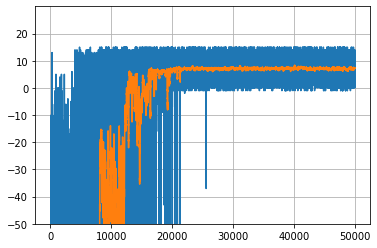

In [155]:
%matplotlib inline
fig,ax = plt.subplots(1)
ax.plot(SARSArewards[0])
ax.plot(np.arange(100,len(SARSArewards[0]) ),SARSArewards[1])

ax.set_ylim(-50,30)
ax.grid()
ax.set_yticks(list(range(-50,30,10)))

# Q-learning Agent


In [156]:
class QLearningAgent(Agent):
  def __init__(self,env,discount_factor,alpha,epsilon):
    super().__init__(env,discount_factor)
    
    self.alpha = alpha
    self.epsilon = epsilon
    self.Q = np.random.rand(self.env.nS, self.env.nA)
   
  def act(self, state): 
    #here choose action according to the epsilon-greedy policy
    sample = np.random.rand()
    if sample > self.epsilon:
      action = np.argmax(self.Q[state,:].flatten())
    else:
      actions = list(range(self.env.nA))
      greedy_action = np.argmax(self.Q[state,:].flatten())
      actions.pop(actions.index(greedy_action))
      action = random.choice(actions)
    return action

   
  def run_one_episode(self):
  
    episode = []
    done = False
    total_reward = 0
    state = self.env.reset()
   
    while (not done):
      action = self.act(state)
      new_state, reward, done, _ = self.env.step(action)      
      # Select greedy action
      greedy_action = np.argmax(self.Q[new_state,:].flatten())
      # Update Q
      self.Q[state,action] += self.alpha * (reward + self.gamma * self.Q[new_state,greedy_action] - self.Q[state,action]) 

      # Update state
      state = new_state

      total_reward += reward
    return total_reward
    
  def run_episodes(self, n, batch_length):
    
    samp_rewards = deque(maxlen=100)
    best_avg_reward = -math.inf
    avg_rewards = []
    rewards = []
    ibatch = 1

    for i in range(n):
      rewards.append(self.run_one_episode())
      samp_rewards.append(rewards[-1])
      if (i >= 100):
        # get average reward from last 100 episodes
        avg_reward = np.mean(samp_rewards)
        # append to deque
        avg_rewards.append(avg_reward)
        # update best average reward
        if avg_reward > best_avg_reward:
          best_avg_reward = avg_reward
        if best_avg_reward >= 9.7:
          print('\nEnvironment solved in {} episodes.'.format(i), end="")
          break
      if (i%batch_length == 0):
        self.epsilon /= (ibatch+1) 
        ibatch +=1

     
    return(rewards, avg_rewards,best_avg_reward)


In [157]:
gamma = 1.0
alpha = 0.9
epsilon = 0.9
Qagent = QLearningAgent(env,gamma,alpha,epsilon)

Qrewards = Qagent.run_episodes(50000,4000)


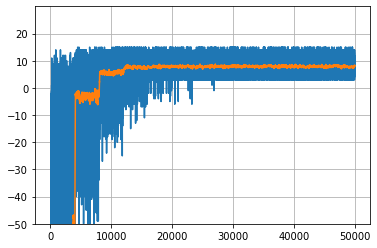

In [158]:
fig,ax = plt.subplots(1)
ax.plot(Qrewards[0])

ax.plot(np.arange(100,len(Qrewards[0]) ),Qrewards[1])

ax.set_ylim(-50,30)
ax.grid()
ax.set_yticks(list(range(-50,30,10)))

# Expected SARSA agent

In [159]:
class ESARSAAgent(Agent):
  def __init__(self,env,discount_factor,alpha,epsilon):
    super().__init__(env,discount_factor)
    self.alpha = alpha
    self.epsilon = epsilon
    self.Q = np.random.rand(self.env.nS, self.env.nA)

  def act(self, state): 
    #here choose action according to the epsilon-greedy policy
    sample = np.random.rand()
    if sample > self.epsilon:
      action = np.argmax(self.Q[state,:].flatten())
    else:
      actions = list(range(self.env.nA))
      greedy_action = np.argmax(self.Q[state,:].flatten())
      actions.pop(actions.index(greedy_action))
      action = random.choice(actions)
    return action

   
  def run_one_episode(self):
    episode = []
    done = False
    total_reward = 0
    state = self.env.reset()
    action = self.act(state)
      
    while (not done):
      new_state, reward, done, _ = self.env.step(action)      
      
      # Update Q
      probabilities = np.full(self.env.nA, self.epsilon/(self.env.nA - 1))
      greedy_action = np.argmax(self.Q[state,:].flatten())
      probabilities[greedy_action] = 1.-self.epsilon

      self.Q[state,action] += self.alpha * (reward + self.gamma * np.sum(probabilities * self.Q[new_state,:]) - self.Q[state,action]) 

      state = new_state
      action = self.act(new_state)
      
      total_reward += reward
     
    return total_reward
    
  def run_episodes(self, n, batch_length):
    
    samp_rewards = deque(maxlen=100)
    best_avg_reward = -math.inf
    avg_rewards = []
    rewards = []
    ibatch = 1

    for i in range(n):
      rewards.append(self.run_one_episode())
      samp_rewards.append(rewards[-1])
      if (i >= 100):
        # get average reward from last 100 episodes
        avg_reward = np.mean(samp_rewards)
        # append to deque
        avg_rewards.append(avg_reward)
        # update best average reward
        if avg_reward > best_avg_reward:
          best_avg_reward = avg_reward
        if best_avg_reward >= 9.7:
          print('\nEnvironment solved in {} episodes.'.format(i), end="")
          break
      if (i%batch_length == 0):
        self.epsilon /= (ibatch+1) 
        ibatch +=1
    
    return(rewards, avg_rewards,best_avg_reward)


In [160]:
gamma = 1.0
alpha = 1.0
epsilon = 0.9
ESARSAagent = ESARSAAgent(env,gamma,alpha,epsilon)


ESARSArewards = ESARSAagent.run_episodes(50000,4000)


In [161]:
ESARSAagent.epsilon

1.0323671037956752e-11

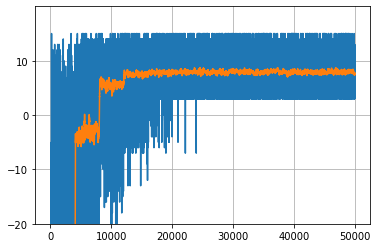

In [162]:
fig,ax = plt.subplots(1)
ax.plot(ESARSArewards[0])

ax.plot(np.arange(100,len(ESARSArewards[0]) ),ESARSArewards[1])

ax.set_ylim(-20,20)
ax.grid()
ax.set_yticks(list(range(-20,20,10)))

Text(0, 0.5, 'Running average total reward per episode \n (window size = 100)')

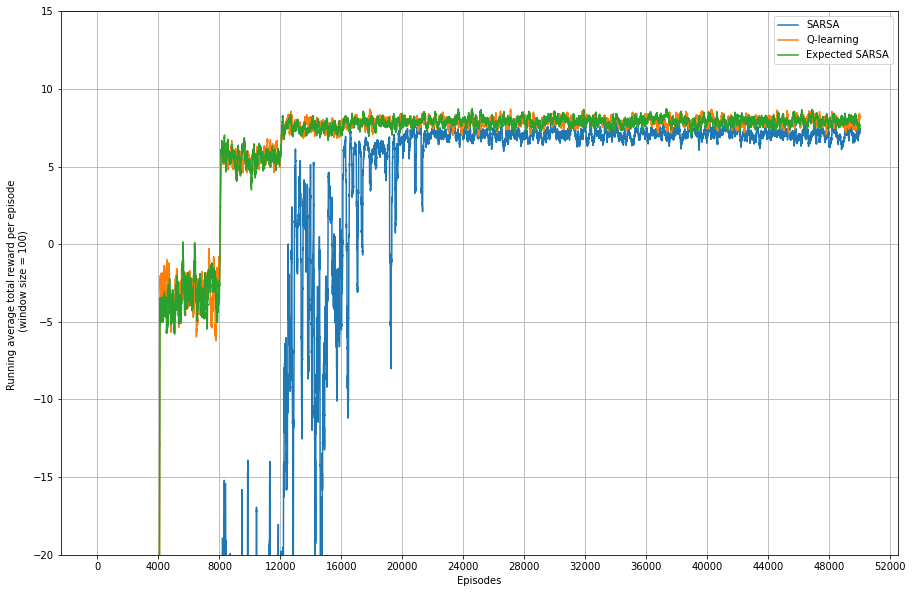

In [181]:
fig,ax = plt.subplots(1, figsize=(15,10))

ax.plot(np.arange(100,len(SARSArewards[0]) ),SARSArewards[1])
ax.plot(np.arange(100,len(Qrewards[0]) ),Qrewards[1])
ax.plot(np.arange(100,len(ESARSArewards[0]) ),ESARSArewards[1])

ax.set_xticks(list(range(0,54000,4000)))
ax.set_ylim(-20,15)
ax.grid()
ax.legend(['SARSA','Q-learning','Expected SARSA'])
ax.set_xlabel('Episodes')
ax.set_ylabel('Running average total reward per episode \n (window size = 100)')

In [187]:

state = env.reset()
#render the environment

done=False  
frames=[]
total_reward = 0
for i in range(100):
  action = ESARSAagent.act(state)
  state, reward, done, _ = env.step(action)
  total_reward += reward
  frames.append({'frame': env.render(mode='ansi'),'state': state,'action': action,'reward': reward})
  if done:
    break
print_frames(frames)
print('Total reward: ' + str(total_reward))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 17
State: 85
Action: 5
Reward: 20
Total reward: 4


In [166]:
print(SARSArewards[2], Qrewards[2],ESARSArewards[2])

8.34 8.7 8.73


In [183]:
SARSAagent.epsilon, Qagent.epsilon, ESARSAagent.epsilon

(1.0323671037956752e-11, 1.0323671037956752e-11, 1.0323671037956752e-11)